In [88]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
import holidays
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_percentage_error

# Load data
- multivariate data for our group uses weekly deaths
- our univariate models required a separate daily dataset for each region because we didn't have enough observations in our weekly dataset once we split by region

In [163]:
data=pd.read_csv('final data/finaldataall.csv', parse_dates=[0])
print(data.shape)
data.tail()

(7306, 146)


,date,location,year,mmwr_week,covid_19_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,...,quarter,dayofyear,dayofmonth,weekofyear,holidays_Holiday,holidays_Normal_day,month_sin,month_cos,dayofweek_sin,dayofweek_cos
7301,2023-02-25,CO,2023,8,22.0,17340235.0,501900.0,6060640.0,10749595.0,28100.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7302,2023-02-25,MI,2023,8,69.0,28917130.0,967600.0,11182320.0,16740610.0,26600.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7303,2023-02-25,MD,2023,8,45.0,21829280.0,616400.0,7305760.0,13876420.0,30700.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7304,2023-02-25,LA,2023,8,24.0,10141420.0,330300.0,4094680.0,5707940.0,8500.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7305,2023-02-25,NM,2023,8,10.0,6047345.0,190600.0,2338600.0,3511145.0,7000.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521


In [73]:
data.columns.to_list()

['year',
 'mmwr_week',
 'weekly_deaths',
 'distributed',
 'distributed_janssen',
 'distributed_moderna',
 'distributed_pfizer',
 'distributed_novavax',
 'distributed_unk_manuf',
 'dist_per_100k',
 'distributed_per_100k_5plus',
 'distributed_per_100k_12plus',
 'distributed_per_100k_18plus',
 'distributed_per_100k_65plus',
 'administered',
 'administered_5plus',
 'administered_12plus',
 'administered_18plus',
 'administered_65plus',
 'administered_janssen',
 'administered_moderna',
 'administered_pfizer',
 'administered_novavax',
 'administered_unk_manuf',
 'admin_per_100k',
 'admin_per_100k_5plus',
 'admin_per_100k_12plus',
 'admin_per_100k_18plus',
 'admin_per_100k_65plus',
 'recip_administered',
 'administered_dose1_recip',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_5plus',
 'administered_dose1_recip_5plus_pop_pct',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_12plus_pop_pct',
 'administered_dose1_recip_18plus',
 'administered_dose1_recip_18plus_pop_pc

In [164]:
data.rename(columns = {'covid_19_deaths': 'weekly_deaths'}, inplace = True)

In [165]:
data = data.drop(['location', 'date.1'], axis = 1)

In [166]:
data.fillna(0, inplace = True)

In [167]:
data['date'] = pd.to_datetime(data['date'])

In [168]:
data.head()

,date,year,mmwr_week,weekly_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,distributed_unk_manuf,...,quarter,dayofyear,dayofmonth,weekofyear,holidays_Holiday,holidays_Normal_day,month_sin,month_cos,dayofweek_sin,dayofweek_cos
0,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
1,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
2,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
3,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
4,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521


In [169]:
data.set_index('date', inplace=True)

# splitting into train test

In [196]:
# Date for splitting training and testing dataset
train_end_date = '2023-01-01'

In [213]:
train = data[data.index < train_end_date]
test = data[data.index >= train_end_date]
print(train.shape, test.shape)

(6974, 143) (332, 143)


# Building baseline models

- conclusion is that the baseline models all have an MAE of about 146
    - these are the models:
        - w/o additional regressors
        - with seasonality
        - with seasonality and holidays

In [106]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = 1 / (n - 1) * np.sum(np.abs(Predicted.iloc[1:].values - Actual.iloc[:-1].values))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

### 1. baseline model without additional regressors

18:44:08 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing


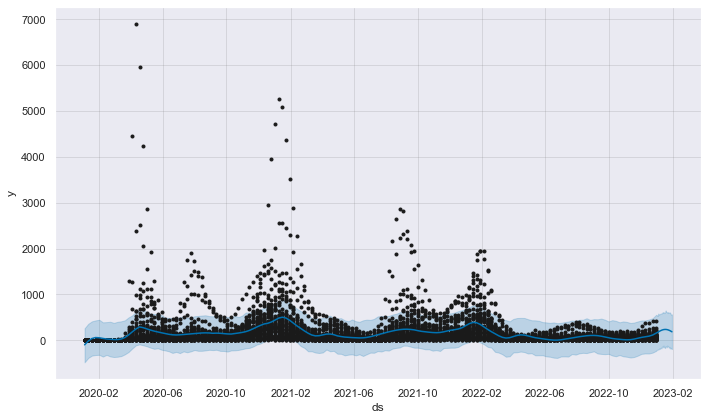

In [91]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

# 30 day forecase
future_baseline = model_baseline.make_future_dataframe(periods=30)

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

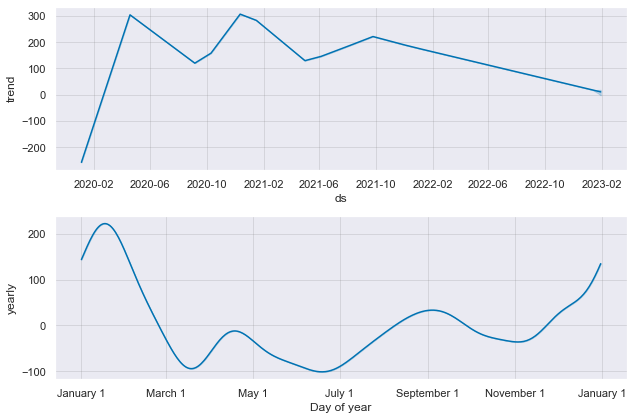

In [113]:
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

In [94]:
# Merge actual and predicted values
performance_baseline = pd.merge(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}), forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 146.8167401878676
The MAPE for the baseline model is 5.0116286368590695


### 2. add seasonality to baseline model

In [111]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Fit the model on the training dataset
model_season.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

19:04:08 - cmdstanpy - INFO - Chain [1] start processing
19:04:10 - cmdstanpy - INFO - Chain [1] done processing


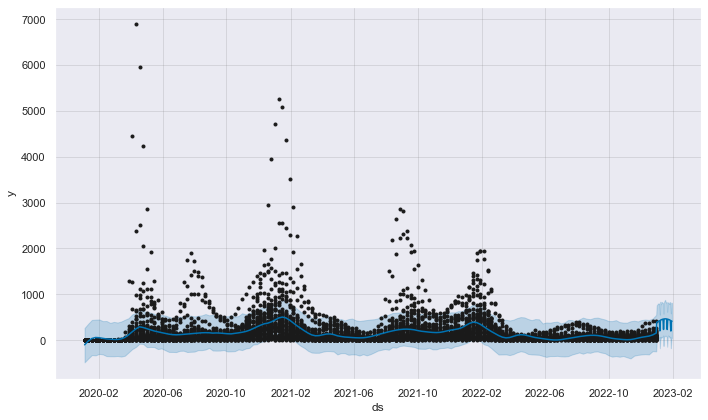

In [112]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=30)

# Make prediction
forecast_season = model_season.predict(future_season)

# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

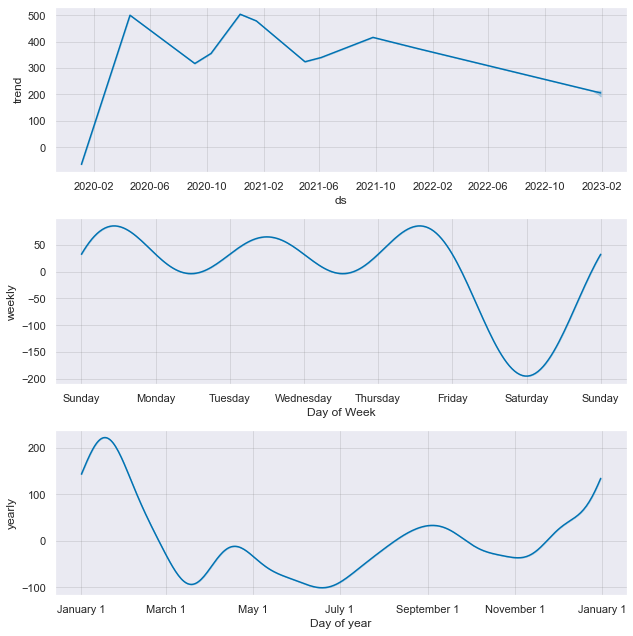

In [114]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

In [116]:
# Merge actual and predicted values
performance_season = pd.merge(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}), forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 146.7864068576751
The MAPE for the seasonality model is 5.010570370769879


### 3. baseline with seasonality and Holiday

In [127]:
# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')

# Fit the model on the training dataset
model_holiday.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

# All the holidays and events
model_holiday.train_holiday_names

21:38:55 - cmdstanpy - INFO - Chain [1] start processing
21:38:58 - cmdstanpy - INFO - Chain [1] done processing


0                                      New Year's Day
1                                        Memorial Day
2                                    Independence Day
3                         Independence Day (observed)
4                                           Labor Day
5                                        Veterans Day
6                                        Thanksgiving
7                                       Christmas Day
8                          Martin Luther King Jr. Day
9                               Washington's Birthday
10                                       Columbus Day
11                          New Year's Day (observed)
12               Juneteenth National Independence Day
13    Juneteenth National Independence Day (observed)
14                           Christmas Day (observed)
dtype: object

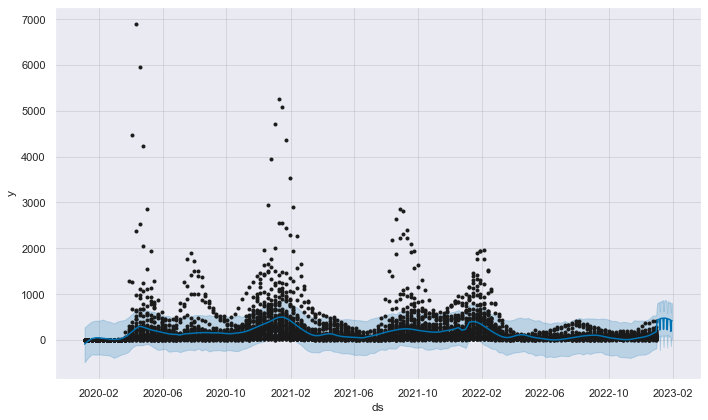

In [130]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=30)

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

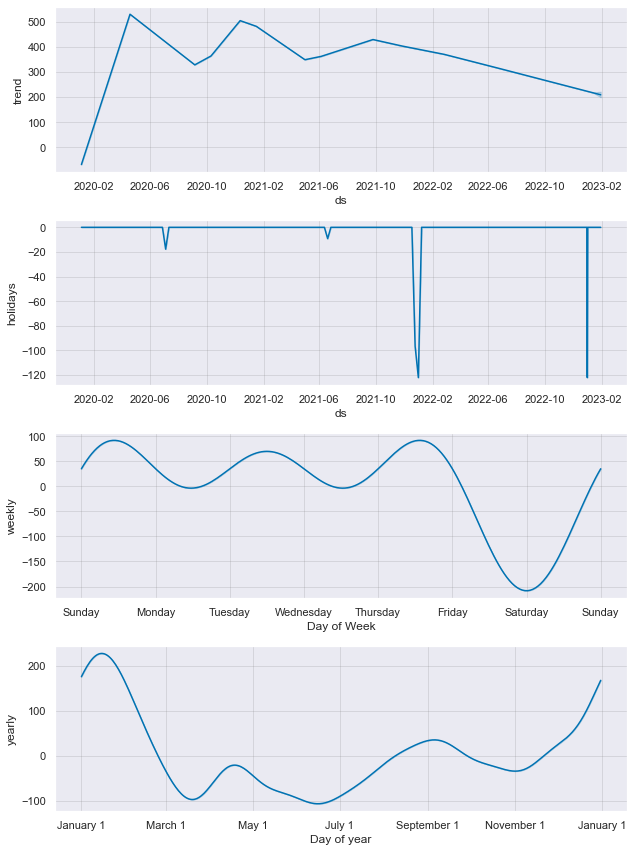

In [131]:
# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);

In [132]:
# Merge actual and predicted values
performance_holiday = pd.merge(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}), forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 146.2942660085678
The MAPE for the holiday/event model is 4.992514088194114


# Building Multivariate Model
        
- the basic models I ran w additional regressors
    - these are the models:
        - w all the regressors: MAE of 98
        - with the regressors + seasonality: MAE of 98
        - with the regressors + seasonality + holidays: MAE of 113

### model with all the regressors

In [133]:
print(train.shape, test.shape)

(6974, 143) (332, 143)


21:50:53 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing


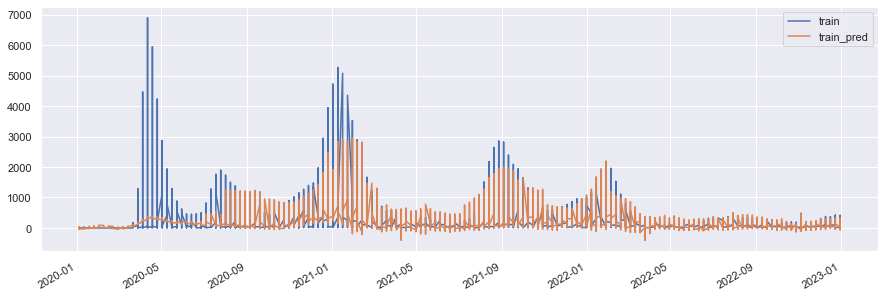

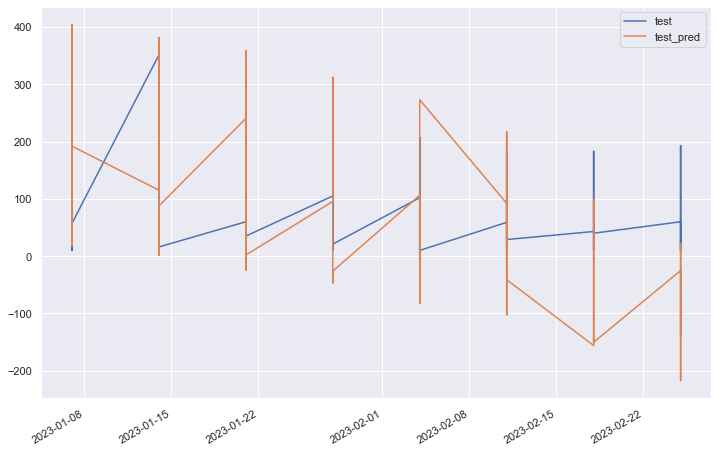

Training Set Metrics:
Training MAE: 173.25615570390914
Training MASE: 1.0079302285002611

Testing Set Metrics:
Testing MAE: 98.5059769913452
Testing MASE: 1.001166493559001


In [134]:
model = prophet.Prophet()
for col in train.columns:
    if col not in ['date', 'weekly_deaths']:
        model.add_regressor(col)
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

train_pred=model.predict(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')

pd.concat([train['weekly_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')
pd.concat([test['weekly_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

# Train

train_mae = mean_absolute_error(train['weekly_deaths'], train_pred['yhat'])
train_mase = MASE(train['weekly_deaths'], train_pred['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)


test_mae = mean_absolute_error(test['weekly_deaths'], test_pred['yhat'])
test_mase = MASE(test['weekly_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

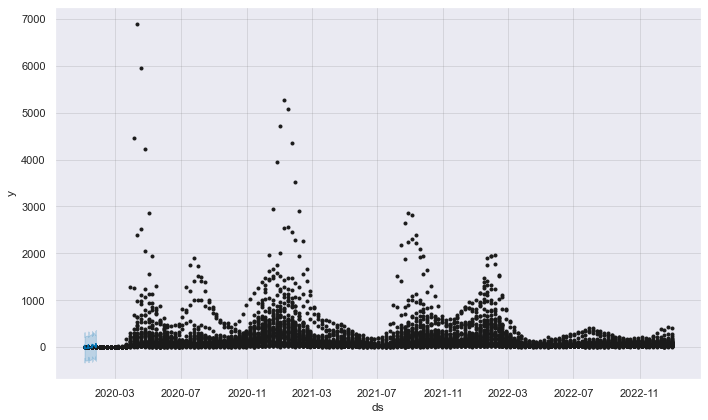

In [135]:
# Create the future dataframe with the same regressors
future = model.make_future_dataframe(periods=30)
for col in df.columns:
    if col not in ['date', 'weekly_deaths']:
        future[col] = df[col]

# Make prediction
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast);

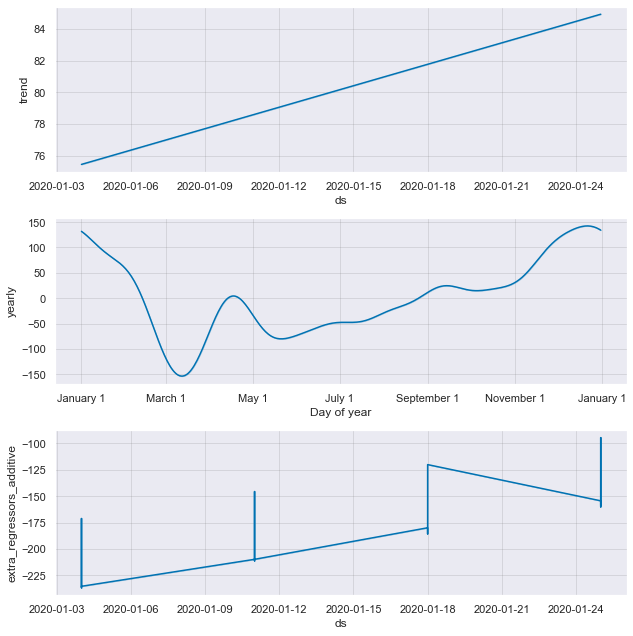

In [136]:
# Visualize the forecast components
model.plot_components(forecast);

### Add holidays and seasonality to model with all the regressors
- makes mae WORSE

In [141]:
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True)
for col in train.columns:
    if col not in ['date', 'weekly_deaths']:
        model.add_regressor(col)
        
model.add_country_holidays(country_name='US')
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

21:55:20 - cmdstanpy - INFO - Chain [1] start processing
21:55:54 - cmdstanpy - INFO - Chain [1] done processing


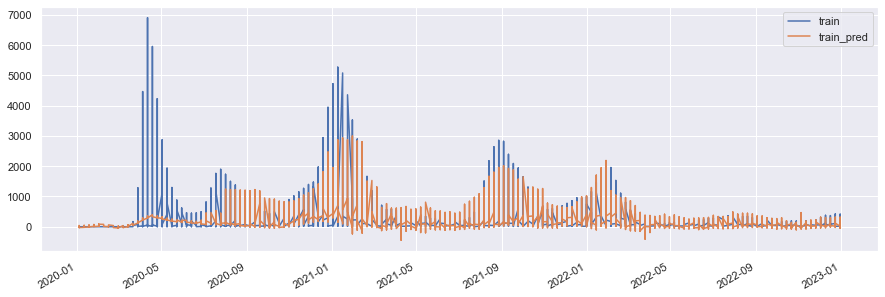

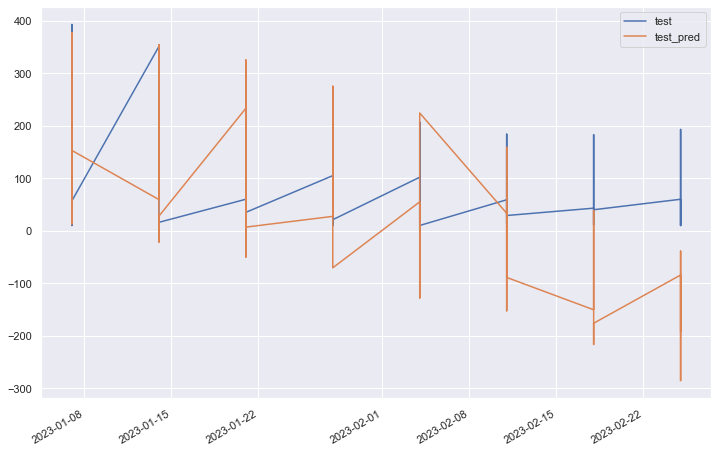

Training Set Metrics:
Training MAE: 172.9204887027343
Training MASE: 1.0075697126698713

Testing Set Metrics:
Testing MAE: 113.00887440578158
Testing MASE: 1.0036040326412317


In [142]:
train_pred=model.predict(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')
pd.concat([train['weekly_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')
pd.concat([test['weekly_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

# Train

train_mae = mean_absolute_error(train['weekly_deaths'], train_pred['yhat'])
train_mase = MASE(train['weekly_deaths'], train_pred['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)


test_mae = mean_absolute_error(test['weekly_deaths'], test_pred['yhat'])
test_mase = MASE(test['weekly_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

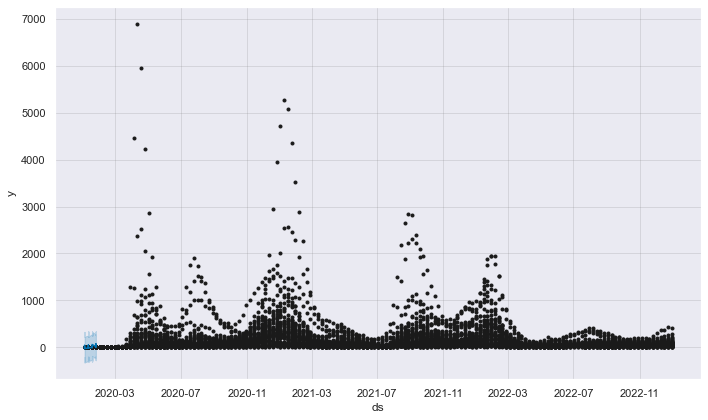

In [143]:
# Create the future dataframe with the same regressors
future = model.make_future_dataframe(periods=30)
for col in df.columns:
    if col not in ['date', 'weekly_deaths']:
        future[col] = df[col]

# Make prediction
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast);

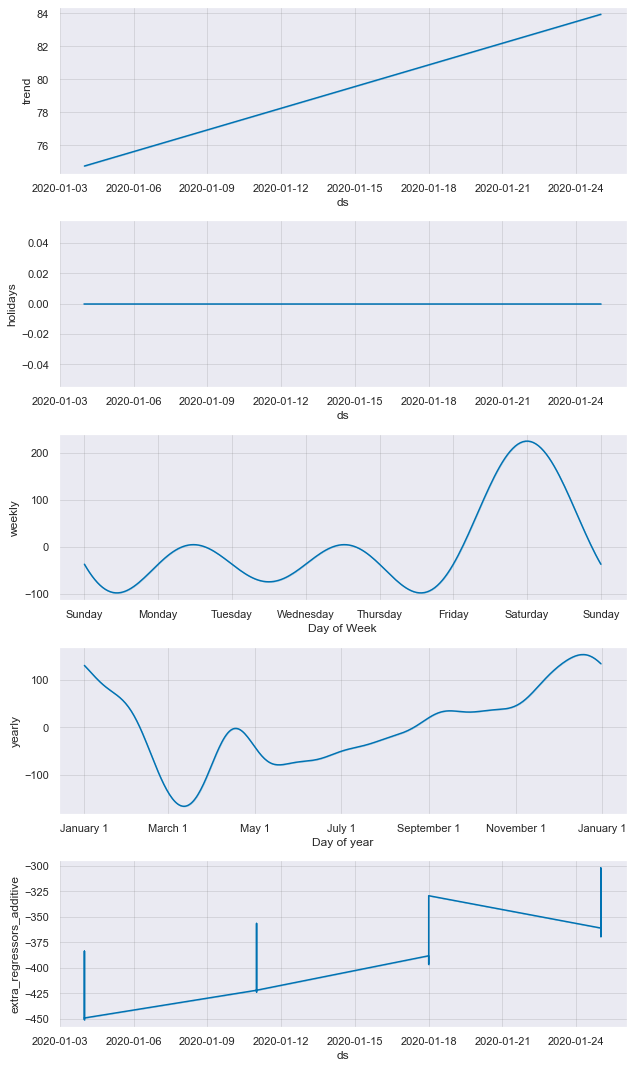

In [144]:
# Visualize the forecast components
model.plot_components(forecast);

# FINAL MODEL Multivariate

### With a log transformation

In [227]:
# Log-transform 'weekly_deaths' in both train and test datasets
train['log_weekly_deaths'] = np.log1p(train['weekly_deaths'])
test['log_weekly_deaths'] = np.log1p(test['weekly_deaths'])

22:44:40 - cmdstanpy - INFO - Chain [1] start processing
22:45:12 - cmdstanpy - INFO - Chain [1] done processing


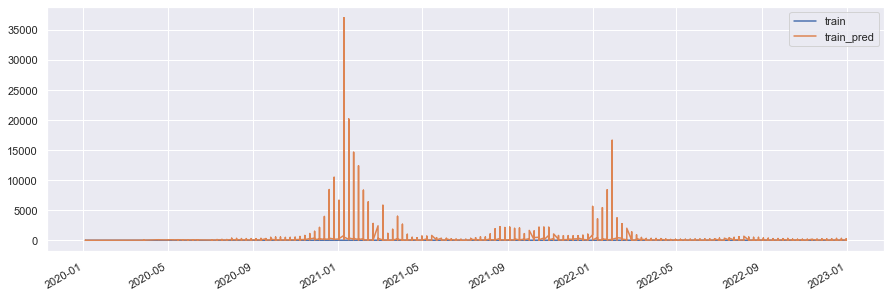

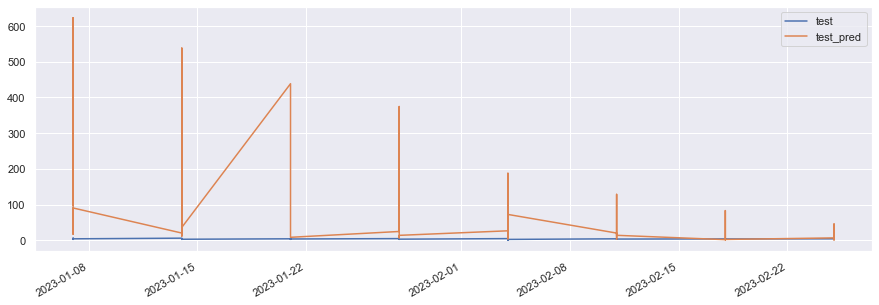

Training Set Metrics:
Training MAE: 183.9670407674638
Training MASE: 1.0137818761937087

Testing Set Metrics:
Testing MAE: 63.33720992052484
Testing MASE: 0.9935350004471354


In [229]:
# Create and fit the Prophet model with log-transformed target variable
model = Prophet()
for col in train.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        model.add_regressor(col)

model = model.fit(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'}))

# Make predictions on the training set
train_pred = model.predict(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
train_pred['yhat'] = np.expm1(train_pred['yhat'])

# Plot the training set predictions
pd.concat([train['log_weekly_deaths'], train_pred['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['train', 'train_pred'])
plt.show()

# Make predictions on the test set
test_pred = model.predict(test.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Plot the test set predictions
pd.concat([test['log_weekly_deaths'], test_pred['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

# Train
train_mae = mean_absolute_error(train['weekly_deaths'], train_pred['yhat'])
train_mase = MASE(train['weekly_deaths'], train_pred['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)

# Test
test_mae = mean_absolute_error(test['weekly_deaths'], test_pred['yhat'])
test_mase = MASE(test['weekly_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


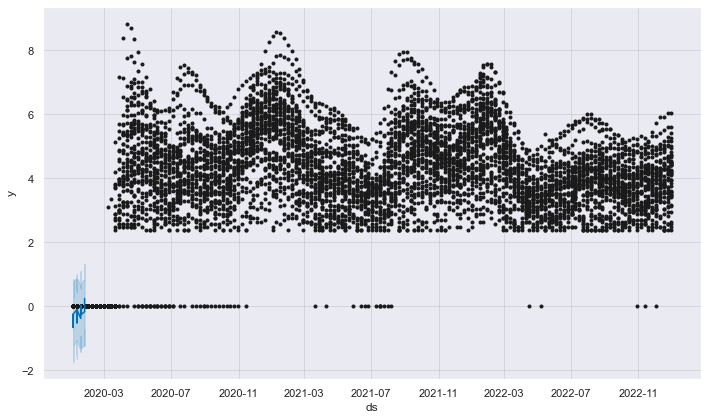

In [230]:
# Create the future dataframe with the same regressors
future = model.make_future_dataframe(periods=30)
for col in df.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        future[col] = df[col]

# Make prediction
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast);

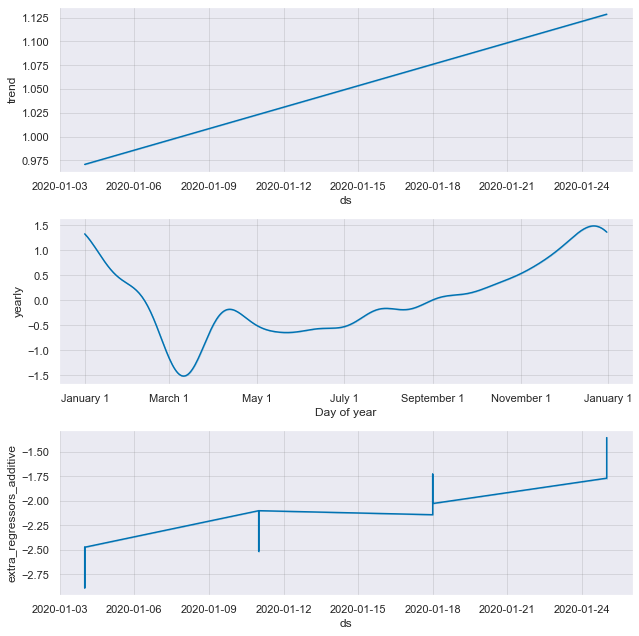

In [231]:
# Visualize the forecast components
model.plot_components(forecast);

### adding seasonality and holidays

22:49:06 - cmdstanpy - INFO - Chain [1] start processing
22:49:36 - cmdstanpy - INFO - Chain [1] done processing


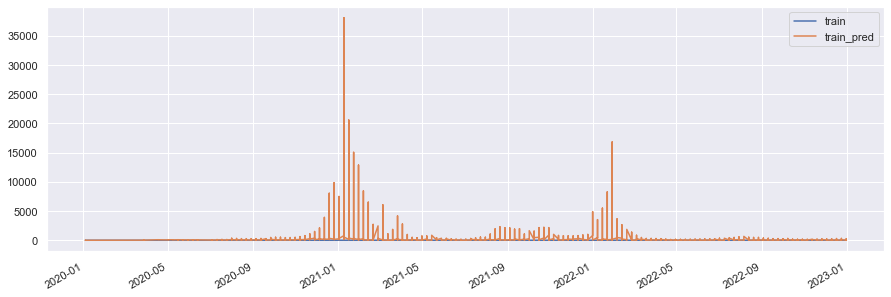

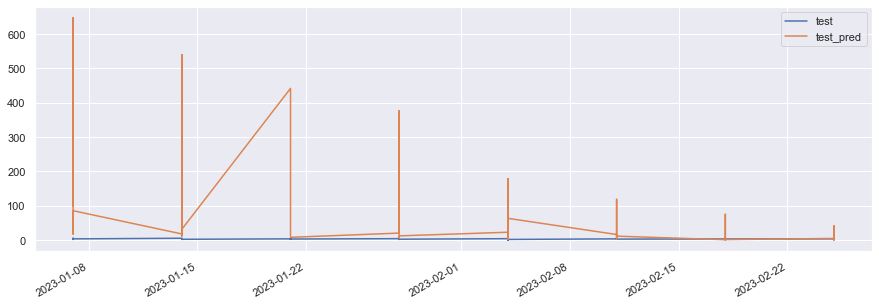

Training Set Metrics:
Training MAE: 184.47252054430052
Training MASE: 1.0140134099438518

Testing Set Metrics:
Testing MAE: 63.54094876627705
Testing MASE: 0.9958597059792597


In [235]:
# Create and fit the Prophet model with log-transformed target variable
model = Prophet(yearly_seasonality = True, weekly_seasonality = True)
for col in train.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        model.add_regressor(col)
model.add_country_holidays(country_name='US')
model = model.fit(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'}))

# Make predictions on the training set
train_pred = model.predict(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
train_pred['yhat'] = np.expm1(train_pred['yhat'])

# Plot the training set predictions
pd.concat([train['log_weekly_deaths'], train_pred['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['train', 'train_pred'])
plt.show()

# Make predictions on the test set
test_pred = model.predict(test.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Plot the test set predictions
pd.concat([test['log_weekly_deaths'], test_pred['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

# Train
train_mae = mean_absolute_error(train['weekly_deaths'], train_pred['yhat'])
train_mase = MASE(train['weekly_deaths'], train_pred['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)

# Test
test_mae = mean_absolute_error(test['weekly_deaths'], test_pred['yhat'])
test_mase = MASE(test['weekly_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

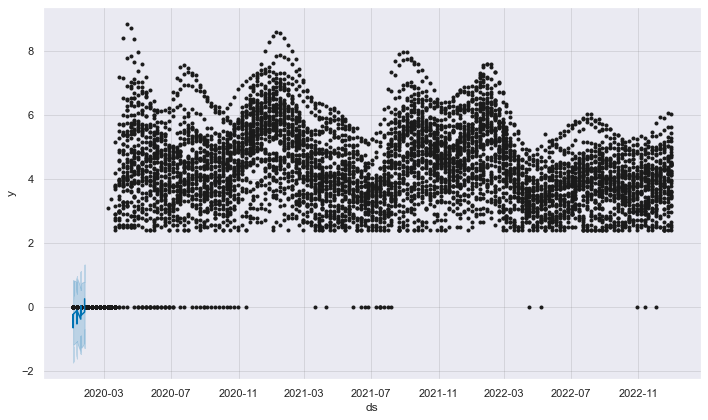

In [236]:
# Create the future dataframe with the same regressors
future = model.make_future_dataframe(periods=30)
for col in df.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        future[col] = df[col]

# Make prediction
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast);

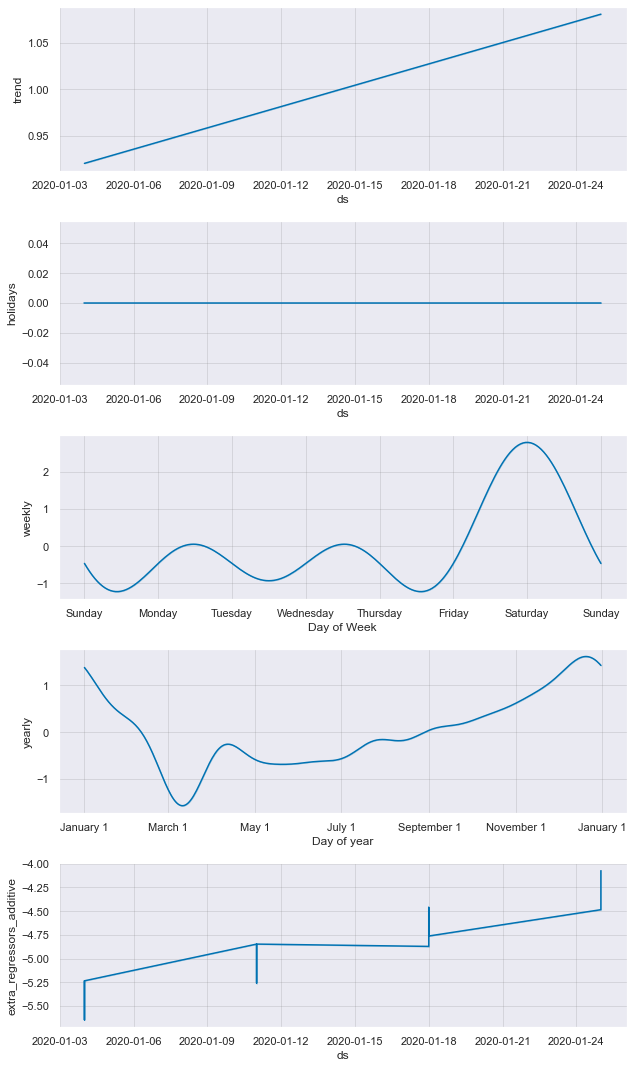

In [237]:
# Visualize the forecast components
model.plot_components(forecast);